# **Modeling**

# **Imports**

In [1]:
#Numpy
import numpy as np
from numpy import median

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

#Warnings
import warnings
warnings.filterwarnings("ignore")

# **Loading Data**

In [2]:
#Loading in the data from the previous notebook
fd = pd.read_csv('fd')

In [3]:
fd.head()

,Order #,Transaction Type,Order Time,Order Date,Delivery Date,Product Total,Delivery,Nontaxable Delivery,Wire Out Fee,Discount,Gift Cards,Tax,Tips,Grand Total,Payment Method,Order Type,Order Method,Year
0,100017453,Sale,03:28:16PM Sat,2018-12-29,2018-12-29,815.00,$0.00,0.0,0.0,0.00,0.0,79.46,0.0,894.46,Credit Card,Taken,Phone,2018
1,100017452,Sale,03:16:50PM Sat,2018-12-29,2018-12-29,249.90,$0.00,0.0,0.0,-124.96,0.0,12.19,0.0,137.13,Credit Card,Taken,Walk-In,2018
2,100017451,Sale,02:58:53PM Sat,2018-12-29,2018-12-29,24.95,$0.00,0.0,0.0,0.00,0.0,2.43,0.0,27.38,Credit Card,Taken,Walk-In,2018
3,100017450,Sale,02:54:45PM Sat,2018-12-29,2018-12-29,635.00,$0.00,0.0,0.0,0.00,0.0,61.91,0.0,696.91,Credit Card,Taken,Phone,2018
4,100017202,Sale,02:48:15PM Sat,2018-12-29,2018-12-23,702.00,$0.00,25.0,0.0,0.00,0.0,68.45,0.0,795.45,Credit Card,Delivery,Walk-In,2018


In [4]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46062 entries, 0 to 46061
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Order #              46062 non-null  int64  
 1   Transaction Type     46062 non-null  object 
 2   Order Time           46062 non-null  object 
 3   Order Date           46062 non-null  object 
 4   Delivery Date        46062 non-null  object 
 5   Product Total        46062 non-null  float64
 6   Delivery             46062 non-null  object 
 7   Nontaxable Delivery  46062 non-null  float64
 8   Wire Out Fee         46062 non-null  float64
 9   Discount             46062 non-null  float64
 10  Gift Cards           46062 non-null  float64
 11  Tax                  46062 non-null  float64
 12  Tips                 46062 non-null  float64
 13  Grand Total          46062 non-null  float64
 14  Payment Method       46062 non-null  object 
 15  Order Type           46062 non-null 

In [5]:
#fd['Delivery Date'] = pd.to_datetime(fd['Delivery Date'])
#fd['Year'] = fd['Delivery Date'].dt.year

In [6]:
filtered_data = fd[(fd['Year'] != 2016) & (fd['Year'] != 2017)]

In [7]:
product_total_by_year = filtered_data.groupby('Year')['Product Total'].sum().reset_index()

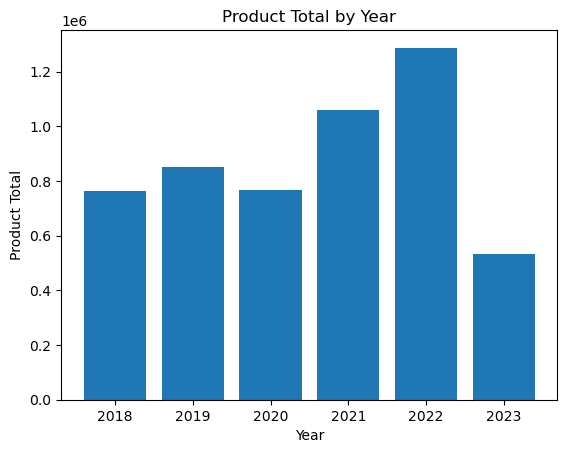

In [8]:
# Create barplot
plt.bar(product_total_by_year['Year'], product_total_by_year['Product Total'])

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Product Total')
plt.title('Product Total by Year')

# Show the plot
plt.show()

In [9]:
def replace_nan(fd):
    # Find categorical and numerical columns
    categorical_cols = fd.select_dtypes(include='object').columns
    numerical_cols = fd.select_dtypes(include=np.number).columns
    date_cols = ['Order Time', 'Order Date', 'Delivery Date']
# Replace NaT values with NaN
    fd = fd.replace(pd.NaT, np.nan)

# Impute missing values with mode for categorical variables
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    fd[categorical_cols] = categorical_imputer.fit_transform(fd[categorical_cols])
# Replace missing values in date columns with most frequent date
    for col in date_cols:
        most_frequent_date = fd[col].mode().values[0]
        fd[col].fillna(most_frequent_date, inplace=True)
        # Impute missing values with median for numerical variables
        numerical_imputer = SimpleImputer(strategy='most_frequent')
    fd[numerical_cols] = numerical_imputer.fit_transform(fd[numerical_cols])

    return fd

In [10]:
#Runing the function to transform the data
transformed_data =replace_nan(fd)

In [11]:
# Function to remove adjustment and refund rows
def remove_adjustment_refund_rows(data):
    # Filter out rows with 'Adjustment' and 'Refund' transaction types
    filtered_data = fd[fd['Transaction Type'].isin(['Sale'])]
    
    return filtered_data

# Example usage:
filtered_data = remove_adjustment_refund_rows(transformed_data)
fd = filtered_data

## **Addressing issue of categorical columns before modeling**

In [12]:
# Assuming 'TargetColumn' is the name of your target variable column
y = fd['Grand Total']

# Drop the target column to get the features
X = fd.drop(columns=['Grand Total'])

In [13]:
# Identify categorical columns
categorical_cols = ['Transaction Type', 'Order Time', 'Order Date', 'Delivery Date', 'Delivery', 'Payment Method', 'Order Type', 'Order Method']

# Convert categorical columns to appropriate data types
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Perform one-hot encoding on categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
X_encoded.columns = encoder.get_feature_names(categorical_cols)
X = pd.concat([X.drop(columns=categorical_cols), X_encoded], axis=1)

MemoryError: Unable to allocate 15.2 GiB for an array with shape (44227, 46062) and data type float64

### **Validation Split**

In [ ]:
#Split X and y
X = fd.drop(columns='Grand Total')
y = fd['Grand Total']

In [ ]:
#Split training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
#Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy= 'mean')

#Scaler
scaler = StandardScaler()

#OneHotEncoder
ohe =OneHotEncoder(handle_unknown='ignore', sparse=True)

#Create Selectors
cat_selector = make_column_selector(dtype_include= 'object')
num_selector = make_column_selector(dtype_include='number')

# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

#cat pipe
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

#Make tuples for preprocessing the categorical and numeric columns
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)          

In [ ]:
#Create Column Transformer
preprocessor= make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

In [ ]:
# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
preprocessor

In [ ]:
# Create a LinearRegression model
regressor = LinearRegression()

# Train the model using the preprocessed training sets
regressor.fit(X_train_preprocessed, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test_preprocessed)

In [ ]:
# Convert the predictions back to the original target labels
y_pred_labels = pd.get_dummies(y_pred).idxmax(axis=1)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [ ]:
#RMSE of the linear Regression Model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

### **Tuning Hyperparameters**

In [ ]:
# Splitting the training set further for hyperparameter tuning
X_train_tune, X_val, y_train_tune, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the parameter grid to search over
param_grid = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'normalize': [True, False]       # Whether to normalize the features before fitting the model
}

# Create the Linear Regression model
model = LinearRegression()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search on the training data
grid_search.fit(X_train_tune, y_train_tune)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_val = best_model.predict(X_val)

# Calculate RMSE for the validation set
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
print("Root Mean Squared Error (Validation):", rmse_val)

# Now, you can use the best_model to predict on the test set and calculate RMSE
y_pred_test = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Root Mean Squared Error (Test):", rmse_test)


# **Save Predictions**

In [ ]:
#Saving the new dataframe to upload in the next notebook
fd.to_csv('Predictions', index=False)